<a href="https://colab.research.google.com/github/menguelx7/Diplodatos/blob/main/Series_de_Tiempo_en_Finanzas/Examen_Clase_1_y_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de tiempo en finanzas
### Entregable clase 1 y 2: Vale para media materia!!

Para aprobar hay que entregar Notebooks con la informacion pedida, comentada para su analisis. 

Notebook Clase 1:
Se pretende el entendimiento de la visualización y curación de una serie de tiempo. 

Notebook Clase 2:
Se pretende estudiar descomposiciones en tendencia, estacionalidad y proceso aleatorio. Usar suavizado exponenciar para predecir la serie de acuerdo a la descomposicion observada.



Grupo: 

Integrantes 

*   Flores Diego
*   Mengual Matias
*   Villagra Ignacio
*   Parada Larrosa Francisco

## Entregable clase 1:

### Exploración de la demanda eléctrica con Python

 ### Problema 1:
 
- Objetivo de este problema: La figura de boxplot de demanda de energía diaria muestra en forma equivocada el eje horario, por lo cual lleva a concluir que de noche la demanda de energia es maxima. Por lo cual es necesario corregirlo. 

- Una forma es modificar la figura, corrigiendo los ejes. Eso deja el resto de la notebook sin modificar (levemente... hay que pasar de dato cada 30 min a dato horario...). 

- La segunda es convertir la zona horaria a Australia/Victoria. Usando **pandas.Series.dt.tz** puede cambiar la zona horaria, como en el siguiente ejemplo



In [1]:
#ejemplo de código posible.... no chequeado para toda la notebook

#datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
#datos['Time'] = datos['Time'].dt.tz_localize('UTC')
#datos['Time'] = datos['Time'].dt.tz_convert('Australia/Victoria')
#datos = datos.set_index('Time')
#datos = datos.asfreq('30min')
#datos = datos.sort_index()

- Su tarea es corregir la zona horaria y correr TODA la notebook con esa corrección, verificando que no haya ambiguedades en las definiciones necesarias para plotear las estacionalidades mensuales y semanales. Como la cantidad de datos es muy grande, las estacionalidades se observan via boxplot.

# Desarrollo:

## Ejercicio 1 
Comenzaremos armando y presentando  el dataset, con el propósito de llegar a poner en evidencia dicho desfasaje de horarios que se está proponiento en el primer entregable. 

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Manipulación de series temporales
# ==============================================================================

from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
from calendar import month_name



Mediante Pandas leemos la base de datos original. Ya se sabe, de la primera clase, que esta base no cuenta con datos nulos.
La misma, tiene una columna la cual muestra en intervalos de 30 minutos la fecha y la hora a la cual se tomaron las mediciones de consumo eléctrico de la ciudad de Melbourne. Lo que se hará a continuación, será a esta base de datos indexar la misma por un  índice cronológico. 

In [3]:
datos = pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')
datos

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [4]:
datos_new=pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')

In [5]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 11:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 11:30:00,3724.835666,17.70,2014-12-31,False


Como se puede ver en la tabla anterior, la base de datos comienza en 2011 y finaliza en 2014. Tal como se menciona al comienzo de este entregable, el problema que se tiene es un desfasaje horario entre la hora local de Victoria, Australia y la GMT. Esto quiere decir que para ahorrar esfuerzos y para facilitar la observación de este problema, debemos tomar un pequeño tramo del dataset y presentarlo en escala horaria. 


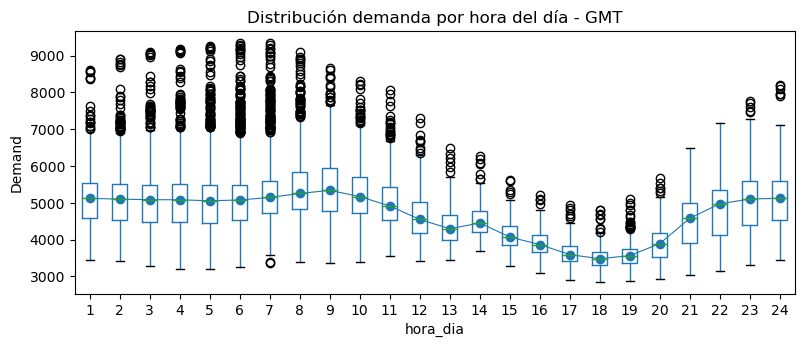

In [6]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día - GMT')
fig.suptitle('');

Es visible que la mayor demanda eléctrica se presenta durante  horas de madrugada, donde además se muestan una gran cantidad outliers. Esto nos da un alerta ya que, normalmente, la industria y los ciudadanos suelen ser más activos durante horas de la mañana y la tarno. 
Suponemos que el huso horario que se utilizó para las mediciones, no es el local sinó el estandar GMT +0. 
Veremos ahora de modificar el horario GMT al de Victoria, Australia. 

In [7]:
#Para trabajar con las dos bases de datos (con tiempo corregido y GMT) utilizaremos "datos_new" 
datos_new['Time'] = pd.to_datetime(datos_new['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos_new['Time'] = datos_new['Time'].dt.tz_localize('UTC')
datos_new['Time'] = datos_new['Time'].dt.tz_convert('Australia/Victoria')
datos_new = datos_new.set_index('Time')
datos_new = datos_new.asfreq('30min')
datos_new = datos_new.sort_index()

In [8]:
datos_new

,Demand,Temperature,Date,Holiday
Time,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 21:30:00+11:00,3873.448714,19.00,2014-12-31,False
2014-12-31 22:00:00+11:00,3791.637322,18.50,2014-12-31,False
2014-12-31 22:30:00+11:00,3724.835666,17.70,2014-12-31,False


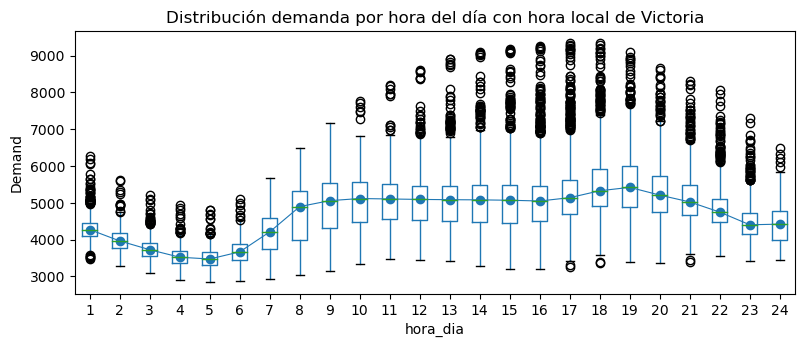

In [9]:
# Gráfico boxplot para estacionalidad diaria con hora de Victoria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos_new['hora_dia'] = datos_new.index.hour + 1
datos_new.boxplot(column='Demand', by='hora_dia', ax=ax)
datos_new.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día con hora local de Victoria')
fig.suptitle('');

Ahora, como vemos en la nueva gráfica, donde se desplazó el huso horario, podemos apreciar un consumo más acorde, donde los mínimos son durante horas de la madrugada y gradualmente comienzan a crecer en las primeras horas de la mañana hasta llegar a un máximo consumo eléctrico entre las 16 y las 18 h. 

Una vez solucionado este problema, continuaremos desarrollando la misma Notebook, presentada en durante la primera clase. Comenzaremos viendo la estacionalidad mensual y semanal: 

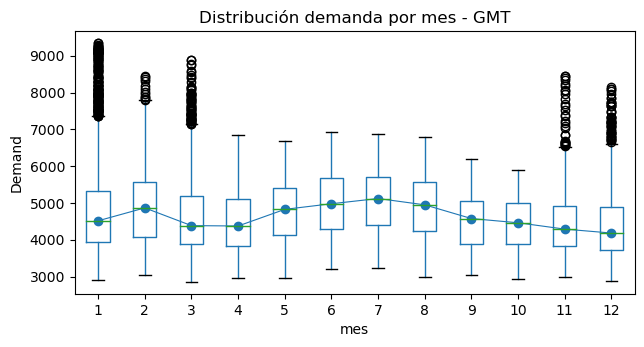

In [10]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes - GMT')
fig.suptitle('');

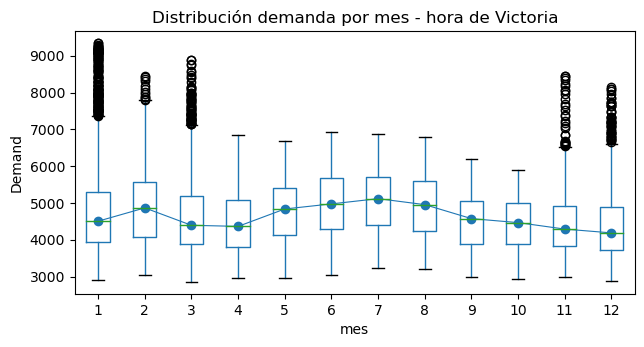

In [11]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos_new['mes'] = datos_new.index.month
datos_new.boxplot(column='Demand', by='mes', ax=ax,)
datos_new.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes - hora de Victoria')
fig.suptitle('');

Viendo la distribución de la demanda de energia eléctrica, en el gráfico de cajas mes a mes, no se notaron cambios entre lasdos gráficas. 

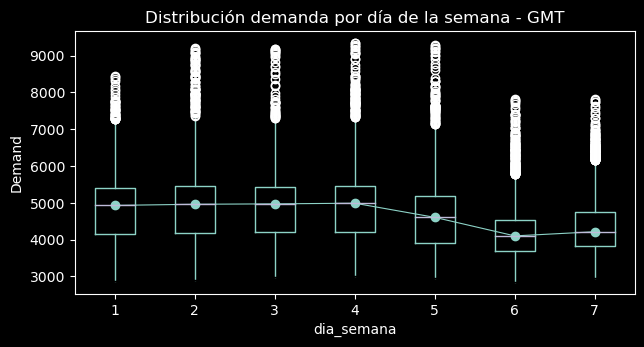

In [12]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana - GMT')
fig.suptitle('');

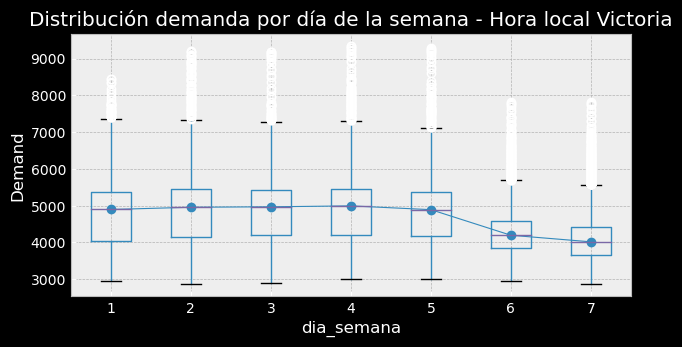

In [13]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos_new['dia_semana'] = datos_new.index.day_of_week + 1
datos_new.boxplot(column='Demand', by='dia_semana', ax=ax)
datos_new.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana - Hora local Victoria')
fig.suptitle('');

A diferencia de las gráficas intermensuales, en este caso se ve una ligera diferencia en la variación del consumo, notandose más entre los dias 5 y 7. Esto se puede deber al defasaje horario entre GMT y GMT+11, donde al haber 11 horas de diferencia, también se presenta un desfasaje de días.  

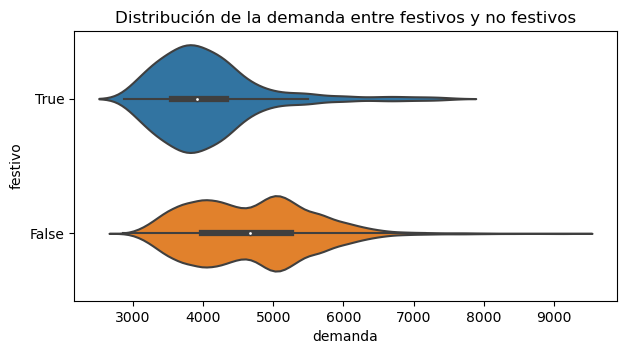

In [14]:
# Grafico violinplot
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

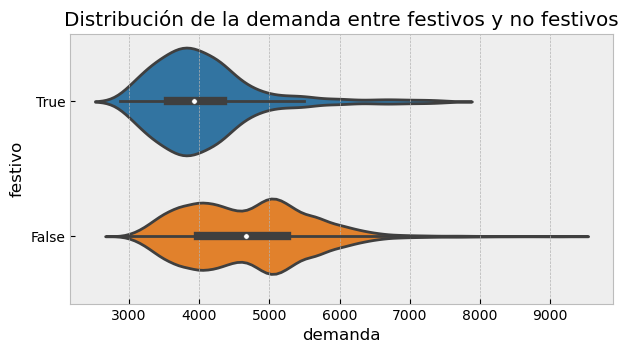

In [15]:
# Grafico violinplot
# ==============================================================================
plt.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos_new.assign(Holiday = datos_new.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

 # Ejercicio 2:
 
- Objetivo de este problema: Estudiar la demanda mensual. Realice gráficos siguiendo la notebook **Visualizacion de datos de polucion de corea.ipynb** realice 

- Gráfico de radar

- Gráfico de barra circular

- Gráfico de ploteo radial

Observe que Ud no tiene mas que una serie, por lo cual es como plotear para un solo distrito. 

## Desarrollo 

En este caso, partimos del dataframe que habíamos generado con la hora corregida. Para estudiar la demanda mensual, vamos a tomar el promedio de cada mes.

In [16]:
#Agregamos una columna con años, ya que nos interesa poder ver año a año el consumo mensual 

In [17]:
#Agregamos una columna con años, ya que nos interesa poder ver año a año el consumo mensual
datos_new['year'] = datos_new.index.year #Creamos una columna con el año

In [18]:
datos_new

,Demand,Temperature,Date,Holiday,hora_dia,mes,dia_semana,year
Time,,,,,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True,1,1,7,2012
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True,1,1,7,2012
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True,2,1,7,2012
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True,2,1,7,2012
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True,3,1,7,2012
...,...,...,...,...,...,...,...,...
2014-12-31 21:30:00+11:00,3873.448714,19.00,2014-12-31,False,22,12,3,2014
2014-12-31 22:00:00+11:00,3791.637322,18.50,2014-12-31,False,23,12,3,2014
2014-12-31 22:30:00+11:00,3724.835666,17.70,2014-12-31,False,23,12,3,2014


Para poder ver en graficos de radar, baras circulares y barras radiales, hemos optado por  tomar una media de la demanda eléctrica de cada mes. A su vez se decidió renombrar el numero  de cada mes, por el nombre propio de los mismos, a fin de facilitar la compransión del lector en las gráficas. 

In [19]:
df_month = datos_new.groupby(['mes']).mean().reset_index()
df_month['mes'] = pd.to_datetime(df_month['mes'], format='%m').dt.month_name()

In [20]:
#Podria darse el caso de querer estudiar un año en particular por lo que 
#armaremos un dataset donde el usuario pueda elegir el año de su interés
year=2012
datos_year = datos_new[datos_new.year==year] #Hacemos un dataset con un año en específico. 
datos_year_mean = datos_year.groupby(datos_year['Demand'].index.month).mean()
datos_year_mean=datos_year_mean.astype(int)
datos_year_mean['mes'] = pd.to_datetime(datos_year_mean['mes'], format='%m').dt.month_name()

In [21]:
list_demand = df_month['Demand'].to_list()
list_demand = list_demand + list_demand[:1]

In [22]:
#months = list(reversed([str(i) for i in list(range(1,13))])) + ['12']
months = list(set(datos_year_mean['mes']))
month_lookup = list(month_name)
months = sorted(months, key=month_lookup.index) 
#Al armarse la lista, la misma queda desordenada por lo que era necesario darle un orden cronologico. 

In [23]:
months = months + months[:1]

## Grafico de radar

En el gráfico tipo radar o radial ,se distribuye una de las variables al rededor de los radiales del gráfico; en este caso usaremos los meses. 

Los circulos concentricos representan la variable demanda o consumo eléctrico, en este caso en MWh. Donde , los circulos de mayor diámetro representan un mayor consumo. 


In [24]:
fig = go.Figure(data=go.Scatterpolar(
  r=list_demand,
  theta= months
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

Vemos en el gráfico de radar que los meses de Enero, Febrero y Julio y Junio son los de mayor demanda eléctrica, mientras que los de Abril, Marzo y Septiembre, Octubre y Noviembre son los de menor demanda. 
Como dato que podría ser de interés, el mayor registro de consumo eléctrico se produce en las estaciones de Verano e Invierno, mientras que en los meses de primavera y otoño, la demanda de energía eléctrica es menor. 

# Circular Bar Plot

Comenzamos armando la función que permitirá realzar gráficos de barras radiales. Estas consisten en un gráfico de barras normal pero distribuidas concentricamente a un círculo. Donde la longitud original de cada barra se ve traducida en el angulo alcanzado por cada semi circulo. 

Si bien esta gráfica puede resultar un tanto complicada de entender a primera vista, resulta llamativa o diferente al reto de graficos de barras, por lo que puede llamar la atención o despertar el interés de los espectadores. Aunque, puede resultar engañoso a simple vista ya que las barras más largas pertenecen a los circulos más excentricos del gráfico, donde el perímetro es mayor, pero esto no quiere decir que las mismas representen una mayor candidad de una variable, respecto a las barras de los circulos más internos. 

In [25]:

def get_color(name, number):
    pal = list(sns.color_palette(palette=name, n_colors=number).as_hex())
    return pal
def circular_bar(input_df, variable, column_name, title):
  pal_vi = get_color('Spectral', len(input_df))
  import math
  plt.gcf().set_size_inches(10, 10)
  ax = plt.subplot(projection='polar')
  input_df.reset_index(inplace=True, drop=True)
  ax.set_theta_zero_location('N')
  ax.set_theta_direction(1)
  ax.set_rlabel_position(0)
  ax.set_thetagrids([], labels=[])
  ax.set_rgrids(range(len(input_df)), labels= input_df[variable])
  ax = plt.subplot(projection='polar')
    
  for i in range(len(input_df)):
    ax.barh(i, input_df[column_name][i]*2*np.pi/max_val,
            label=input_df[variable][i], color=pal_vi[i])
  plt.title("Electric Demand MWh // " + title)
  plt.legend(bbox_to_anchor=(1, 1), loc=2)
  return ax

In [26]:
#Grafico de barra circular
max_val = max(datos_year_mean['Demand'])*1.01        #set max value
pal = list(sns.color_palette(palette='YlOrRd', n_colors=len(list_demand)).as_hex())

En este caso elegimos ver el consumo electrico y comparar mes a mes. Aqui vemos que Febrero, Junio, Julio y Agosto representan los meses de mayor demanda eléctrica del año, mientras que Diciembre y Marzo la demanda es mínima. 

<PolarAxesSubplot:title={'center':'Electric Demand MWh // Periodo Mensual'}>

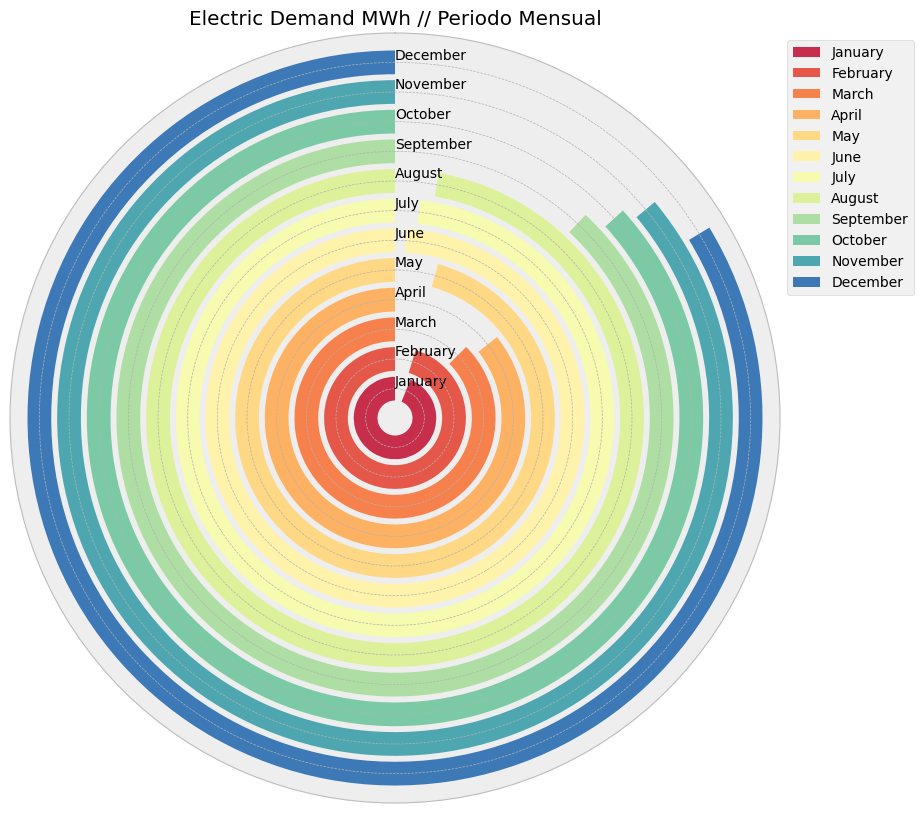

In [27]:
#list_month = months
#listdf_monthly = [datos_year_mean[datos_year_mean['mes']==str(i)] for i in list_month]

#keep_sname = []
#order = range(len(listdf_monthly))

circular_bar(datos_year_mean, 'mes', 'Demand', 'Periodo Mensual')


## Grafico de Ploteo Radial

En la gráfico de barras radiales es similar en cierta medida al de radar, ya que una de las variables se distribuyen de forma angular al rededor de un círculo, en este caso los meses. La demanda o consumo eléctrico es medida en función de circulos concéntricos, donde los valores crecen conforme auneta el radio de dichos ciculos. 

In [28]:
#Grafico de ploteo radial 
#set color palette, lower and max values 
pal = list(sns.color_palette(palette='CMRmap_r', n_colors=len(datos_year_mean)).as_hex())
lowerLimit = 0
max_v = datos_year_mean['Demand'].max()

def radial_plot(input_df, variable,column_name, title):
    input_df.reset_index(inplace=True, drop=True)
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)
    plt.axis()

    heights = input_df[column_name]
    width = 2*np.pi / len(input_df.index)

    indexes = list(range(1, len(input_df.index)+1))
    angles = [element * width for element in indexes]

    bars = ax.bar(x=angles, height=heights, width=width, bottom=lowerLimit,
                  linewidth=1, edgecolor="white", color=pal)
    
    labelPadding = 2

    for bar, angle, height, label in zip(bars, angles, heights, input_df[variable]):
        rotation = np.rad2deg(angle)
        alignment = ""
      
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        ax.text(x=angle, y=lowerLimit + bar.get_height() + labelPadding,
                s=label, ha=alignment, va='center', rotation=rotation, 
                rotation_mode="anchor")
    
        ax.set_thetagrids([], labels=[])
        plt.title("Demanda electrica mensual // " + title)
    return ax

<PolarAxesSubplot:title={'center':'Demanda electrica mensual // Promedio Mensual'}>

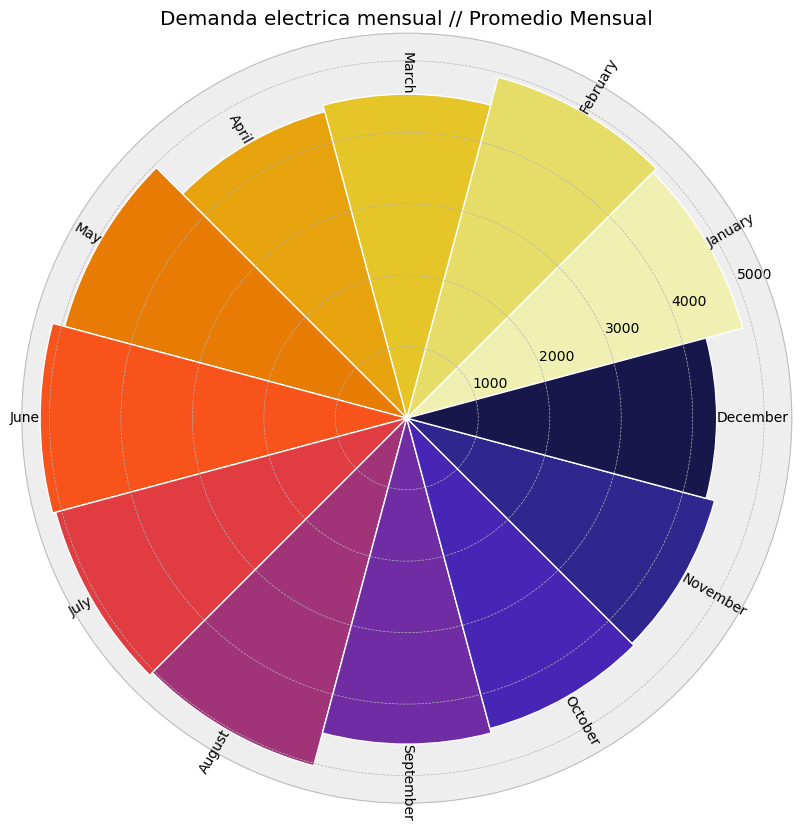

In [29]:
radial_plot(datos_year_mean, 'mes','Demand', 'Promedio Mensual')

En todos los gráficos puede observarse de forma muy clara el mayor consumo promedio de los meses de junio, julio y agosto. 

# Entregable clase 2:

### Exploración de la demanda eléctrica con Python

### Problema 1:
 
- Objetivo de este problema: Realizar descomposiciones en tendencia y estacionalidad de la serie original de demanda horaria,  de la serie de demanda mensual creada en el punto anterior y del zoom de demanda horaria ploteado.  Dar una opinion de lo observado.

A partir del trabajo presentado en clases: Comenzamos por vizualizar la información existente en la base de datos en cuestion

In [30]:
datos_new.head()

,Demand,Temperature,Date,Holiday,hora_dia,mes,dia_semana,year
Time,,,,,,,,
2012-01-01 00:00:00+11:00,4382.825174,21.40,2012-01-01,True,1,1,7,2012
2012-01-01 00:30:00+11:00,4263.365526,21.05,2012-01-01,True,1,1,7,2012
2012-01-01 01:00:00+11:00,4048.966046,20.70,2012-01-01,True,2,1,7,2012
2012-01-01 01:30:00+11:00,3877.563330,20.55,2012-01-01,True,2,1,7,2012
2012-01-01 02:00:00+11:00,4036.229746,20.40,2012-01-01,True,3,1,7,2012


En primer lugar, graficamos la serie completa para tener una idea del comportamiento de la demanda.

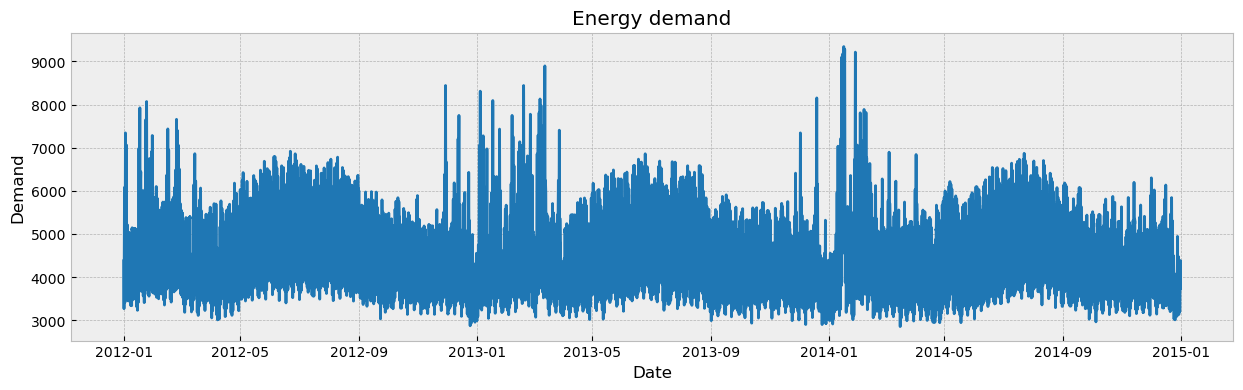

In [31]:
plt.figure(figsize=(15,4), dpi=100)
plt.plot(datos_new[['Demand']], color='tab:blue')
plt.gca().set(title='Energy demand',xlabel='Date', ylabel='Demand')
plt.show()

Ya en este gráfico se puede observar que hay estacionaludad anual, que el mayor consumo promedio mensual parece ser en julio y que hay muchos picos de demanda durante los primeros meses del año. Vamos a separar la serie en los conjuntos de train, validación y test. Serán utilizados en el siguiente punto.

In [32]:
# Separación datos train-val-test
# ==============================================================================
datos = datos_new.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos_new.loc[: fin_train, :]
datos_val   = datos_new.loc[fin_train:fin_validacion, :]
datos_test  = datos_new.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2012-01-01 00:00:00+11:00 --- 2013-12-31 23:30:00+11:00  (n=35088)
Fechas validacion : 2014-01-01 00:00:00+11:00 --- 2014-11-30 23:30:00+11:00  (n=16032)
Fechas test       : 2014-12-01 00:00:00+11:00 --- 2014-12-31 23:30:00+11:00  (n=1488)


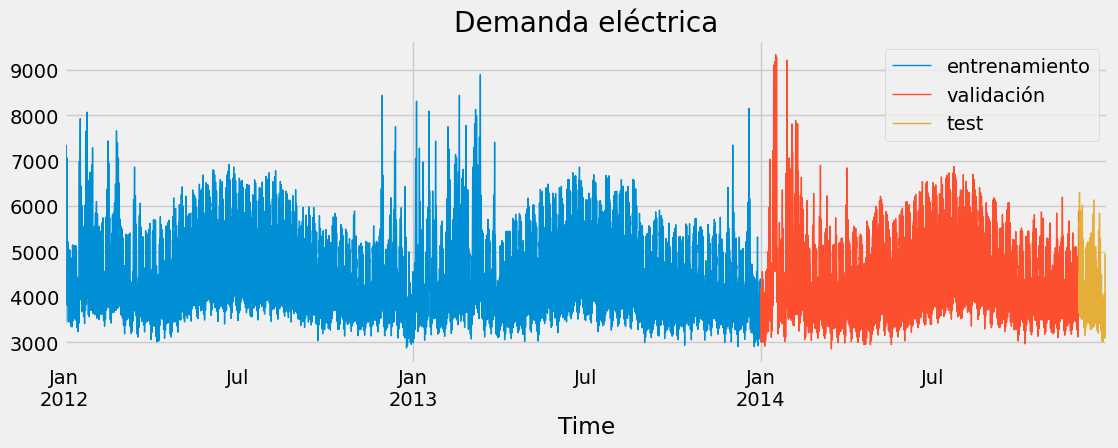

In [33]:
# Gráfico serie temporal
# ==============================================================================
#plt.style.use('default')
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

Ahora vamos a hacer un zoom en la serie para observar con más detalle este fragmento.

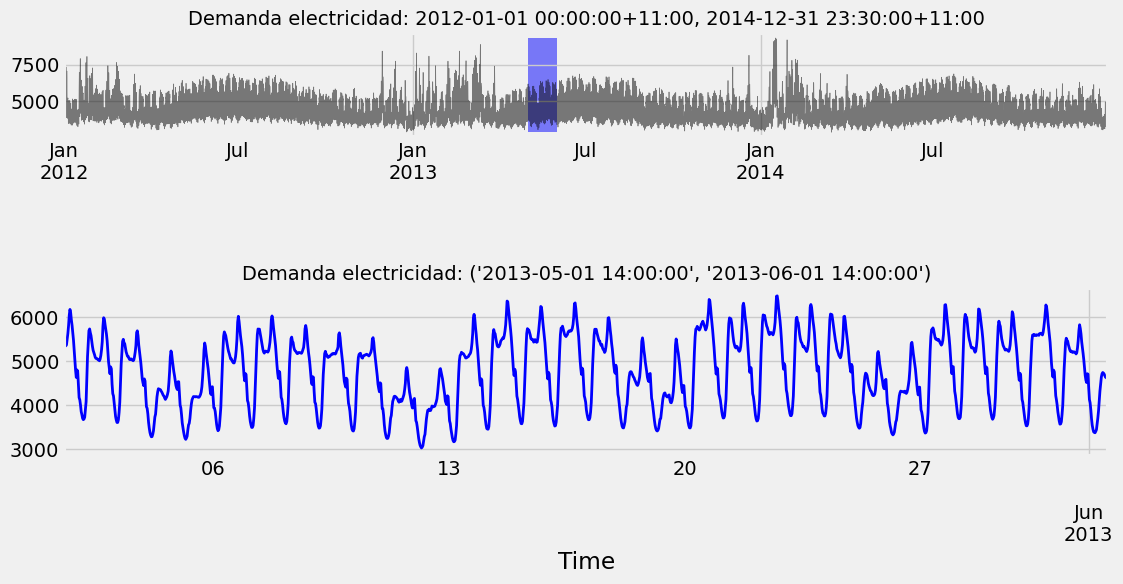

In [34]:
# Gráfico serie temporal con zoom
# ==============================================================================
#plt.style.use('Solarize_Light2')
plt.style.use('fivethirtyeight')
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_new.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos_new.Demand)
max_y = max(datos_new.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos_new.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos_new.index.min()}, {datos_new.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Aquí se puede observar que hay una clara estacionalidad semanal, consumos más elevados durante la semana laboral (lunes a viernes) y menor consumo en los fines de semana.

In [35]:
datos_zoom = datos_new.loc[zoom[0]: zoom[1]]

Ahora vamos a realizar la descomposición de la serie original horaria, de la mensual y del zoom en tendencia, estacionalidad y ruido.

## Serie Original

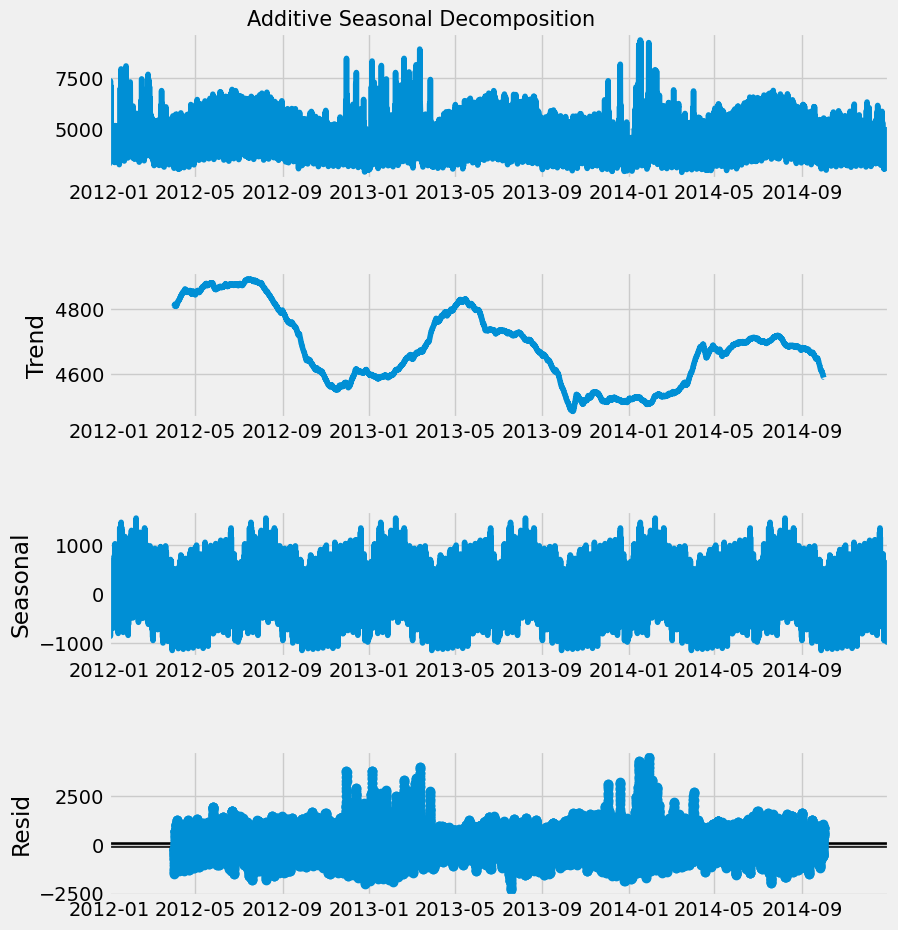

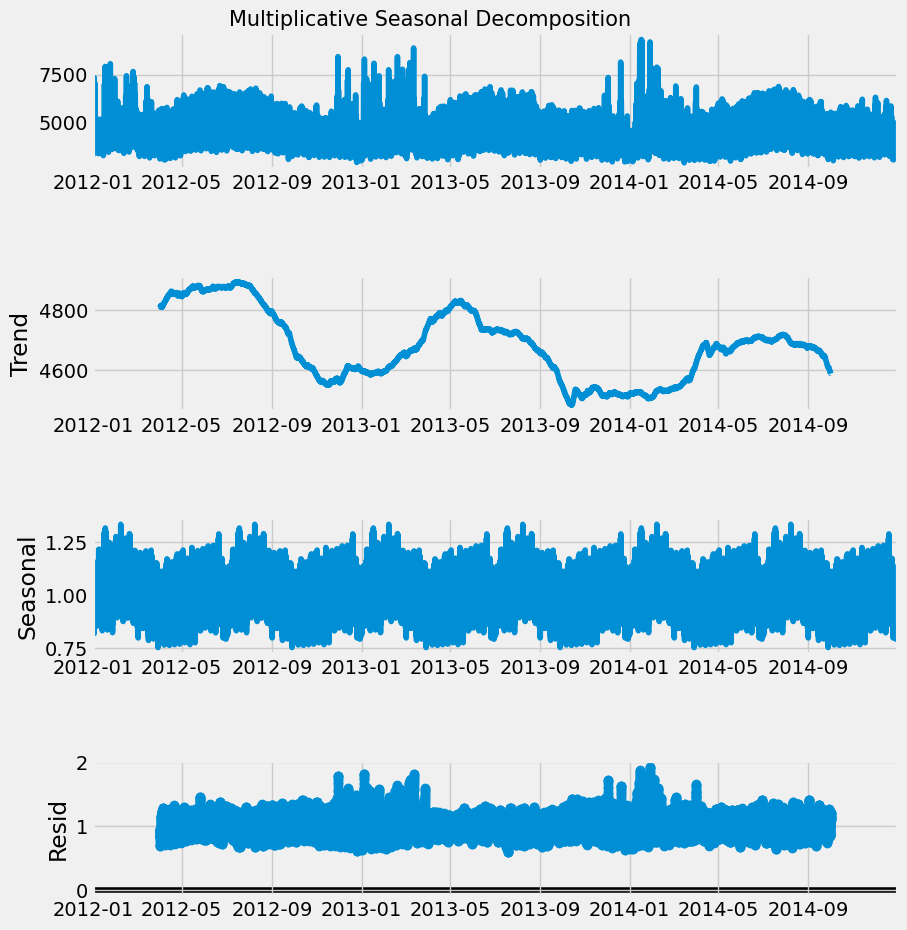

In [36]:
decomposition_df = pd.DataFrame(datos_new.Demand)
seasonal_a = seasonal_decompose(decomposition_df, model='additive', period=365*24)
seasonal_m = seasonal_decompose(decomposition_df, model='multiplicative', period=365*24)
fig_1 = seasonal_a.plot()
fig_2 = seasonal_m.plot()
fig_1.suptitle('Additive Seasonal Decomposition', fontsize=15, color='black')
fig_1.set_figheight(10)
fig_1.set_figwidth(10)
fig_2.suptitle('Multiplicative Seasonal Decomposition', fontsize=15, color='black')
fig_2.set_figheight(10)
fig_2.set_figwidth(10)

plt.show()

De acuerdo a lo que se observa, la tendencia de la demanda viene siendo decreciente en los últimos años. Nuevamente podemos observar el componente estacional que presenta el consumo de energía eléctrica. Por último, los residuos parecen distribuirse uniformemente, con algunos picos en los primeros meses del año pero mayormente alrededor del cero, lo que resulta bastante lógico.

## Serie Mensual
Dado que en el problema anterior habíamos creado un dataframe en el que teníamos la demanda promedio mensual de toda la serie, aquí vamos a crear otro dataframe donde tengamos la serie de forma mensual diferenciando por año.

In [37]:
list_YM = [i.split(" ")[0][:-3] for i in  list(datos_new['Date'])]
datos_new['YM'] = list_YM

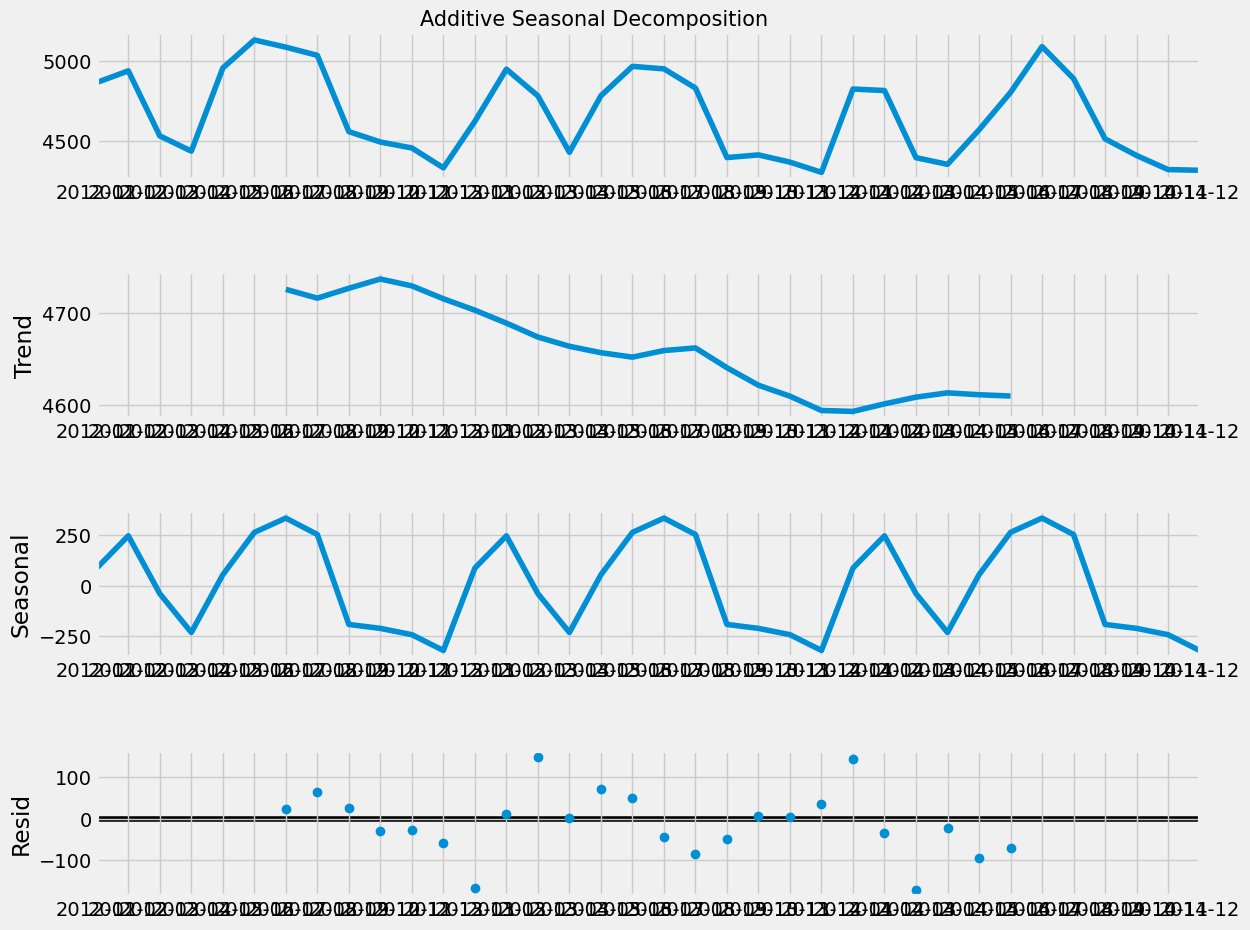

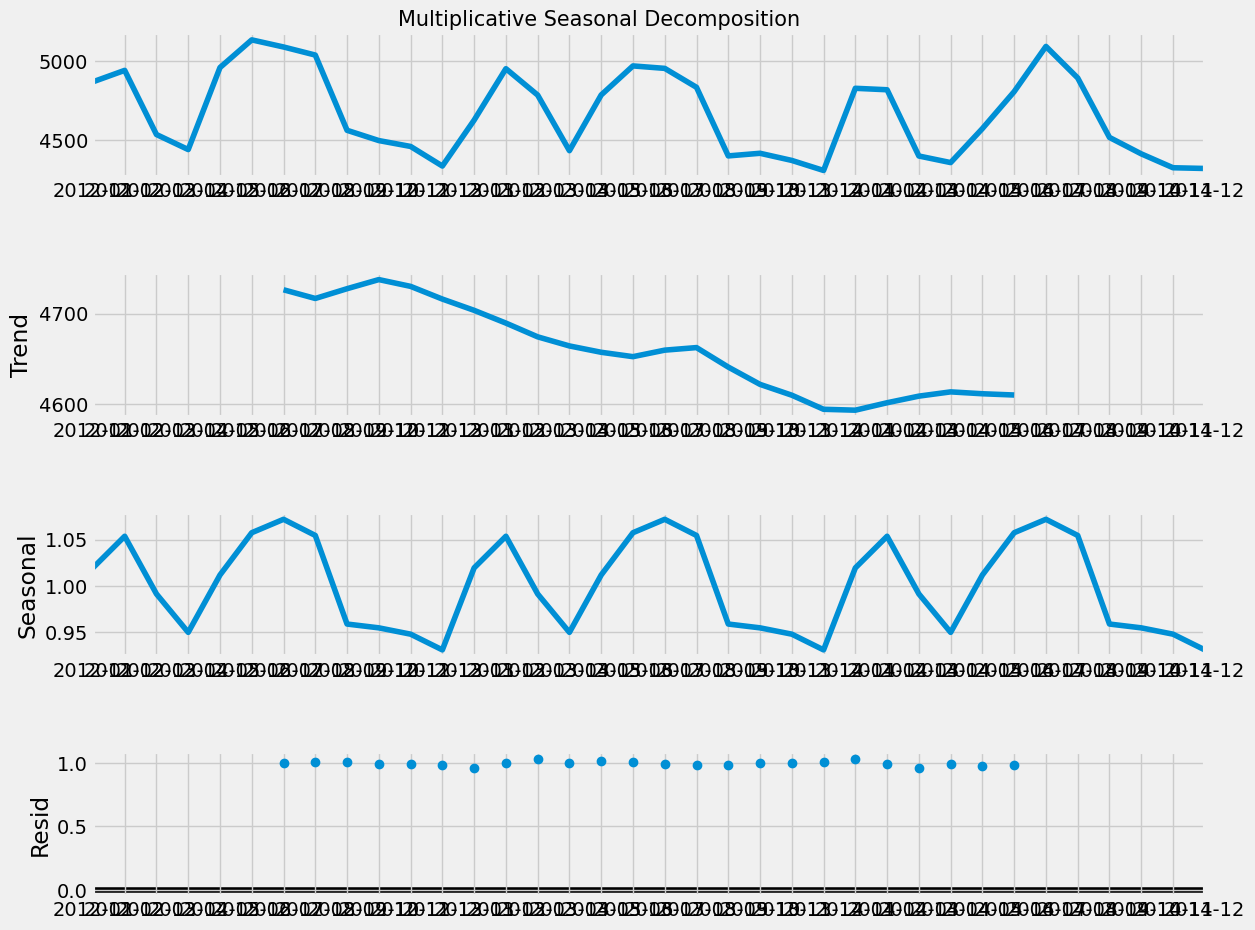

In [38]:
datos_new_mes = datos_new[['YM','Demand']].groupby('YM').mean()
decomposition_df = pd.DataFrame(datos_new_mes.Demand)
seasonal_a = seasonal_decompose(decomposition_df, model='additive', period=12)
seasonal_m = seasonal_decompose(decomposition_df, model='multiplicative', period=12)
fig_1 = seasonal_a.plot()
fig_2 = seasonal_m.plot()
fig_1.suptitle('Additive Seasonal Decomposition', fontsize=15, color='black')
fig_1.set_figheight(10)
fig_1.set_figwidth(15)
fig_2.suptitle('Multiplicative Seasonal Decomposition', fontsize=15, color='black')
fig_2.set_figheight(10)
fig_2.set_figwidth(15)
plt.show()

En el caso de la serie mensual, nuevamente podemos observar la tendencia decreciente del consumo mensual a medida que avanzamos, al igual que el componente estacional que marca incrementos del consumo en los meses de junio, julio y agosto como ya se habia mencionado. 

## Serie Zoom

In [39]:
datos_zoom

,Demand,Temperature,Date,Holiday,hora_dia,mes,dia_semana,year
Time,,,,,,,,
2013-05-01 14:00:00+10:00,5399.746202,15.1,2013-05-01,False,15,5,3,2013
2013-05-01 14:30:00+10:00,5406.941786,15.5,2013-05-01,False,15,5,3,2013
2013-05-01 15:00:00+10:00,5350.199586,14.2,2013-05-01,False,16,5,3,2013
2013-05-01 15:30:00+10:00,5374.452608,14.8,2013-05-01,False,16,5,3,2013
2013-05-01 16:00:00+10:00,5500.344146,14.5,2013-05-01,False,17,5,3,2013
...,...,...,...,...,...,...,...,...
2013-06-01 12:00:00+10:00,4636.012430,15.2,2013-06-01,False,13,6,6,2013
2013-06-01 12:30:00+10:00,4628.843458,15.5,2013-06-01,False,13,6,6,2013
2013-06-01 13:00:00+10:00,4614.822116,15.7,2013-06-01,False,14,6,6,2013


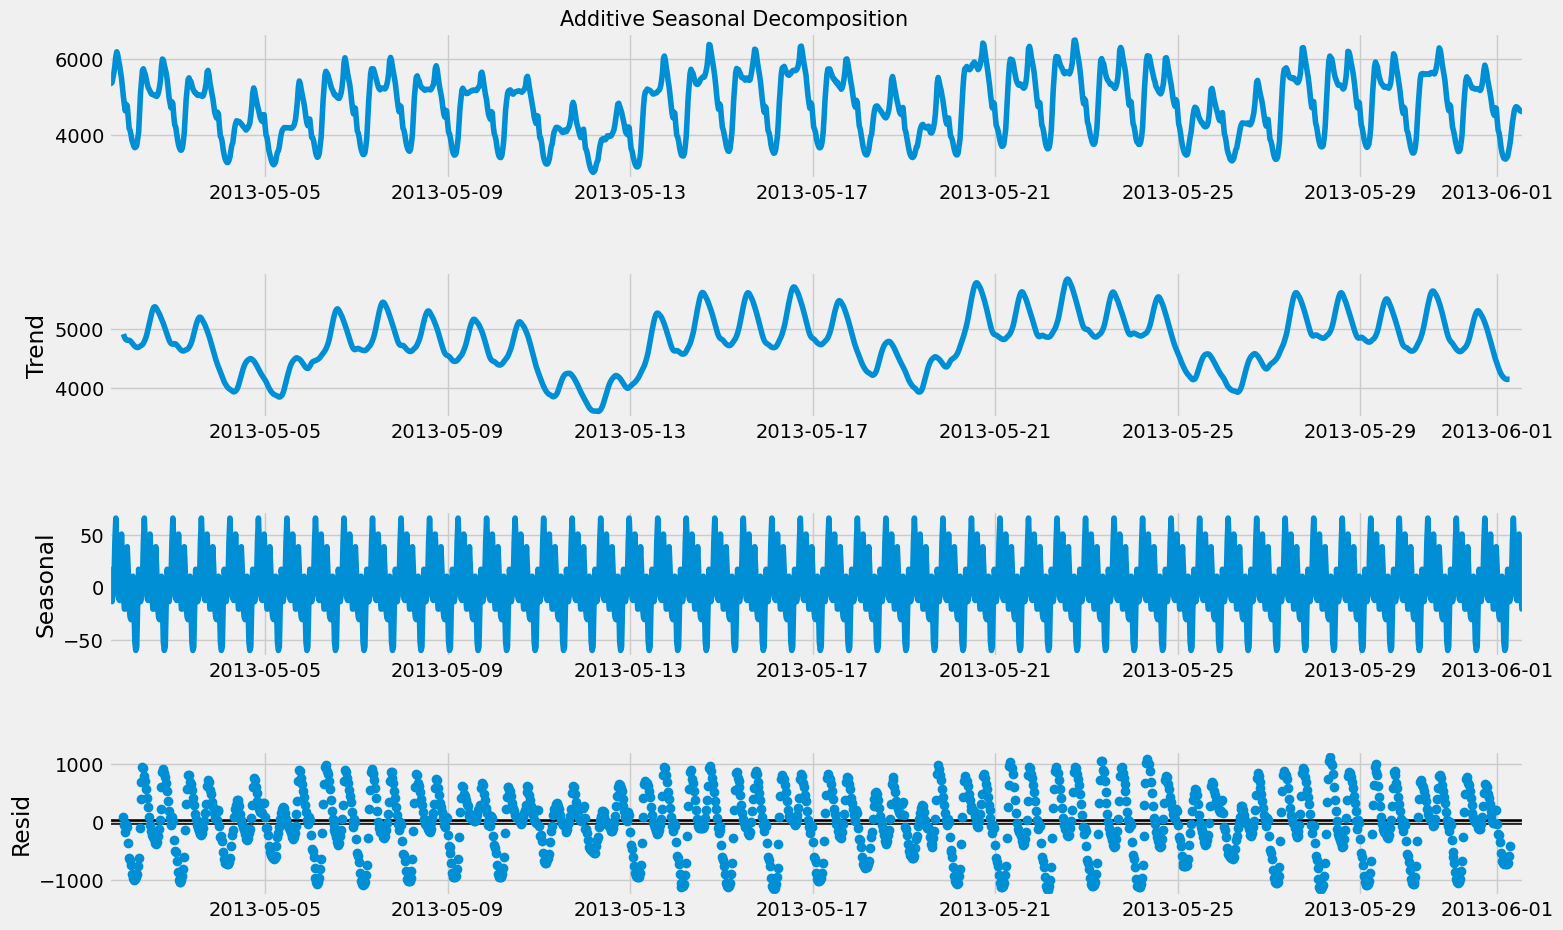

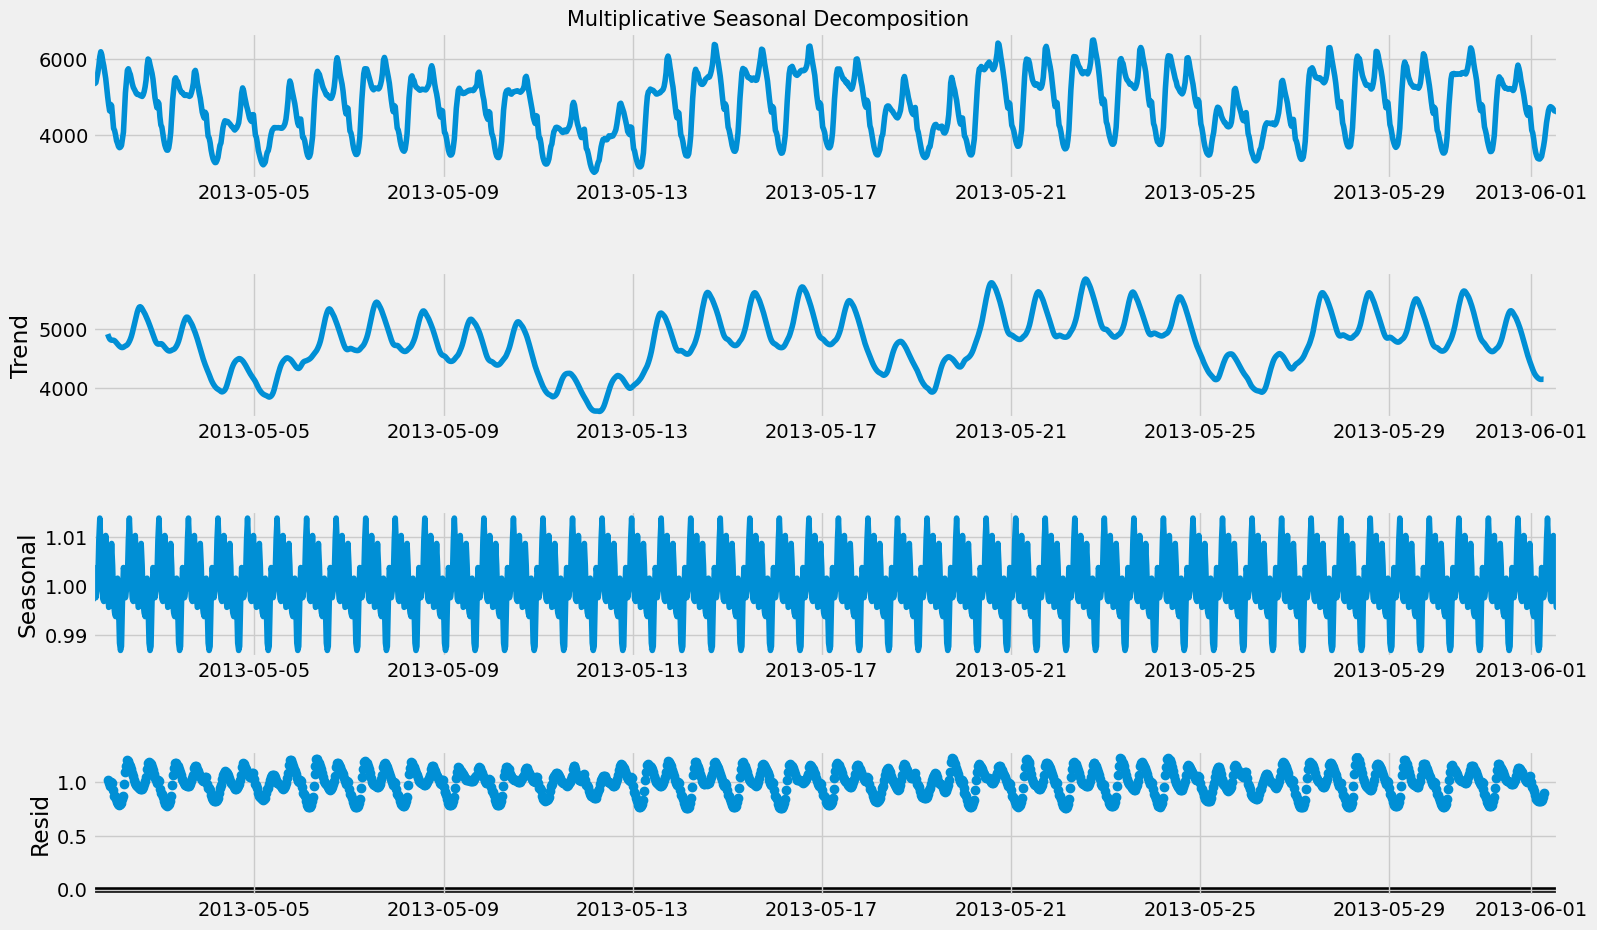

In [40]:
decomposition_df = pd.DataFrame(datos_zoom.Demand)
seasonal_a = seasonal_decompose(decomposition_df, model='additive', period=30)
seasonal_m = seasonal_decompose(decomposition_df, model='multiplicative', period=30)
fig_1 = seasonal_a.plot()
fig_2 = seasonal_m.plot()
fig_1.suptitle('Additive Seasonal Decomposition', fontsize=15, color='black')
fig_1.set_figheight(10)
fig_1.set_figwidth(20)
fig_2.suptitle('Multiplicative Seasonal Decomposition', fontsize=15, color='black')
fig_2.set_figheight(10)
fig_2.set_figwidth(20)

plt.show()

En el caso del zoom que habíamos realizado sobre la demanda eléctrica, podemos observar que en este caso la tendencia es levemente creciente. Esto se debe a las fechas que tomamos, ya que el consumo de los meses de junio suele ser mayor que el de los meses de mayo. Por otro lado, se puede observar claramente la estacionalidad de la serie de acuerdo a los días de la semana, como ya mencionamos anteriormente.

# Entregable Clase 2 Problema 2:

- Objetivo de este problema: Realizar suavizado exponencial, suavizado de Holt y suavizado de Holt-Winter para las tres series anteriores y hacer una prediccion de 24 steps (un mes en el caso horario, un año en el caso mensual ). 
- Encontrar los parámetros usando el set de validación y RMSE. 

- Predecir usando TODA la serie (train mas validacion) y comparar con TEST . 

- Pltear la serie completa y la prediccion para observar el comportamiento de cada uno de los suavizados.

- Dar una opinion de la bondad del método para esta serie. 

Tomaremos las funciones que se presentaron en el Notebook presentado en clases. 
Los mismos fueron "stationarity smoothing and seasonality" y "Suavizado exponencial para prediccion madrid". 

In [41]:
def ses_optimizer(train, val, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

### Serie original

Comenzaremos analizando la serie original, donde aplicaremos el Suavizado Simple Exponencial (SES), el Suavizado Doble Exponencial(suavizado de Holt) y el Suavizado Triple exponencial (Suavizado de Holt-Winter). Luego, continuaremos con una serie mensual que contemplará un año y finalmente una serie horaria que contemplará un mes. 

#### Simple Exponential Smoothing (SES)

El suavizado exponencial simple (SES en inglés), es un modelo de previsión que amplía la media móvil básica añadiendo ponderaciones a períodos anteriores. A medida que el número de observaciones aumentan, si se toman valores de alfa grandes, es decir, cercanos a 1, lleva a que las observaciones más recientes tengan mayor influencia en la predicción, que las mas antiguas. 

In [42]:
datos = pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')

In [43]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos_new = datos[['Demand']]
datos_new.head()

In [45]:
# Separación datos train-val-test
# ==============================================================================
datos_new = datos_new.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos_new.loc[:fin_train, :]
datos_val   = datos_new.loc[fin_train:fin_validacion, :]
datos_test  = datos_new.loc[fin_validacion:, :]
datos_train_val = datos_new.loc[:fin_validacion,:]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print(f"Fechas train_val      : {datos_train_val.index.min()} --- {datos_train_val.index.max()}  (n={len(datos_train_val)})")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:30:00  (n=35088)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:30:00  (n=16032)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=1439)
Fechas train_val      : 2012-01-01 00:00:00 --- 2014-11-30 23:30:00  (n=51120)


In [46]:
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(datos_train.Demand, datos_val.Demand, alphas, step=16032)

best_alpha: 0.01 best_mae: 985.367


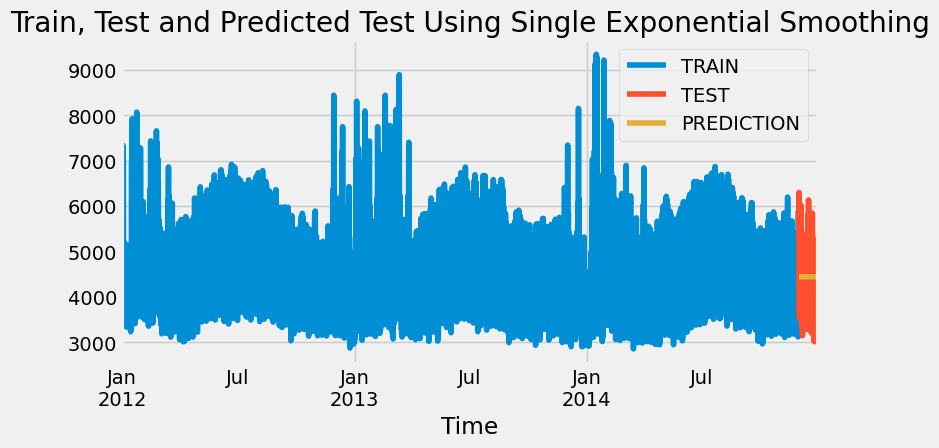

In [47]:
ses_model = SimpleExpSmoothing(datos_train_val.Demand).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(1439)

def plot_prediction(y_pred, label):
    plt.figure(figsize=(8,4), dpi=100)
    datos_train_val["Demand"].plot(legend=True, label="TRAIN")
    datos_test["Demand"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")

Observamos que la predicción no es para nada buena, solo una línea constante, qie se puede ver en color amarillo sobre la gráfica que representa al test. 

#### Suavizado Exponencial Doble (Suavizado de Holt)

El suavizado exponencial doble es para analizar datos que muestran una tendencia, agrega ecuaciones adicionales al suavizado exponencial simple para capturar el nivel y la tendencia de la serie, utilizando el parámetro beta. 

También se lo denomina a veces método de tendencia lineal de Holt, y puede demostrarse que produce predicciones equivalentes al ARIMA(0,2,2).

Al usar el paquete statsmodels todo lo que tenemos que indicar es si la tendencia es aditiva o multiplicativa. Esto se discute más adelante en el núcleo, pero simplemente, la tendencia aditiva y multiplicativa se trata de si la tendencia es consistente o parece crecer, como una función exponencial, por ejemplo.

Si la tendencia es consistente entonces es aditiva, si la tendencia crece entonces es multiplicativa. También parte de la implementación de suavizado exponencial de statsmodels es un argumento `amortiguado`.

El método lineal de Holt tiende a mostrar una tendencia constante indefinidamente en el futuro. El parámetro `amortiguado` corrige esta tendencia infinita amortiguando la tendencia. Hay un parámetro amortiguado entre 0 y 1 donde los valores más cercanos a 1 son los mismos que en un modelo no amortiguado. Podemos establecer estos parámetros nosotros mismos, pero en la práctica, simplemente establecemos si incluir o no el parámetro amortiguado.

In [48]:
def des_optimizer(train, val, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(datos_train.Demand, datos_val.Demand, alphas, betas, step=16032)


des_model = ExponentialSmoothing(datos_train_val.Demand, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(1439)


best_alpha: 0.01 best_beta: 0.01 best_mae: 1013.7144


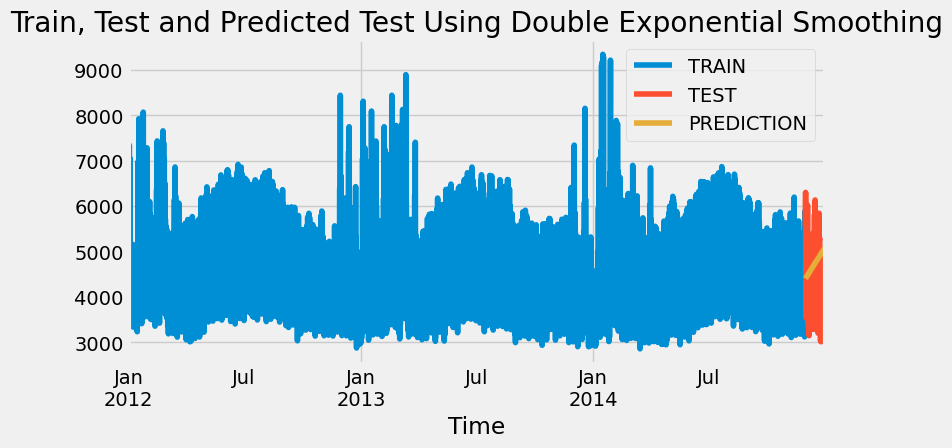

In [49]:
plot_prediction(y_pred, "Double Exponential Smoothing")

La predicción no es buena. Captura una tendencia creciente llegando a valores muy altos de demanda.

#### Suavizado Exponencial Triple (Suavizado de Holt-Winter)
El suavizado exponencial triple, tambien conocido como Métidi de Holt-Winter. Se utiliza para tratar los datos de series temporales que contienen un componente estacional.

Este método se basa en tres ecuaciones de suavizado: componente estacionario, tendencia y estacional. Tanto la estacionalidad como la tendencia pueden ser aditivas o multiplicativas.

In [50]:
def tes_optimizer(train, val, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=).fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(datos_train.Demand, datos_val.Demand, abg, step=16032)

tes_model = ExponentialSmoothing(datos_train_val.Demand, trend="add", seasonal="add", seasonal_periods=).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(720)


SyntaxError: invalid syntax (467726006.py, line 4)

### Serie mensual



In [ ]:
datos = pd.read_csv('https://raw.githubusercontent.com/menguelx7/Diplodatos/main/vic_elec.csv', sep=',')
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')

In [ ]:
datos_mensual = datos.asfreq('M')
datos_mensual = datos_mensual[['Demand']]
datos_mensual.head()

,Demand
Time,
2011-12-31 13:00:00,4382.825174
2012-01-31 13:00:00,4277.935374
2012-02-29 13:00:00,4267.430818
2012-03-31 13:00:00,3919.046338
2012-04-30 13:00:00,4610.045098


In [ ]:
len(datos_mensual)

36

In [ ]:
datos_mensual

,Demand
Time,
2011-12-31 13:00:00,4382.825174
2012-01-31 13:00:00,4277.935374
2012-02-29 13:00:00,4267.430818
2012-03-31 13:00:00,3919.046338
2012-04-30 13:00:00,4610.045098
2012-05-31 13:00:00,5073.296750
2012-06-30 13:00:00,4781.812698
2012-07-31 13:00:00,4983.526432
2012-08-31 13:00:00,4952.966108


In [ ]:
# Separación datos train-val-test
# ==============================================================================
#datos2 = datos2.loc['2012-01-31 00:00:00': '2014-12-31 00:00:00']
fin_train = '2013-12-31 00:00:00'       #'2013-12-31 00:00:00'
fin_validacion = '2014-06-30 00:00:00'  #'2014-11-30 00:00:00'

datos2_train = datos_mensual.loc[:fin_train, :]
datos2_val   = datos_mensual.loc[fin_train:fin_validacion, :]
datos2_test  = datos_mensual.loc[fin_validacion:, :]
datos2_train_val = datos_mensual.loc[:fin_validacion, :]

print(f"Fechas train      : {datos2_train.index.min()} --- {datos2_train.index.max()}  (n={len(datos2_train)})")
print(f"Fechas validacion : {datos2_val.index.min()} --- {datos2_val.index.max()}  (n={len(datos2_val)})")
print(f"Fechas test       : {datos2_test.index.min()} --- {datos2_test.index.max()}  (n={len(datos2_test)})")
print(f"Fechas test_val       : {datos2_train_val.index.min()} --- {datos2_train_val.index.max()}  (n={len(datos2_train_val)})")

Fechas train      : 2011-12-31 13:00:00 --- 2013-11-30 13:00:00  (n=24)
Fechas validacion : 2013-12-31 13:00:00 --- 2014-05-31 13:00:00  (n=6)
Fechas test       : 2014-06-30 13:00:00 --- 2014-11-30 13:00:00  (n=6)
Fechas test_val       : 2011-12-31 13:00:00 --- 2014-05-31 13:00:00  (n=30)


#### Simple Exponential Smoothing (SES)

In [ ]:
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(datos2_train.Demand, datos2_val.Demand, alphas, step=6)

best_alpha: 0.01 best_mae: 200.4745


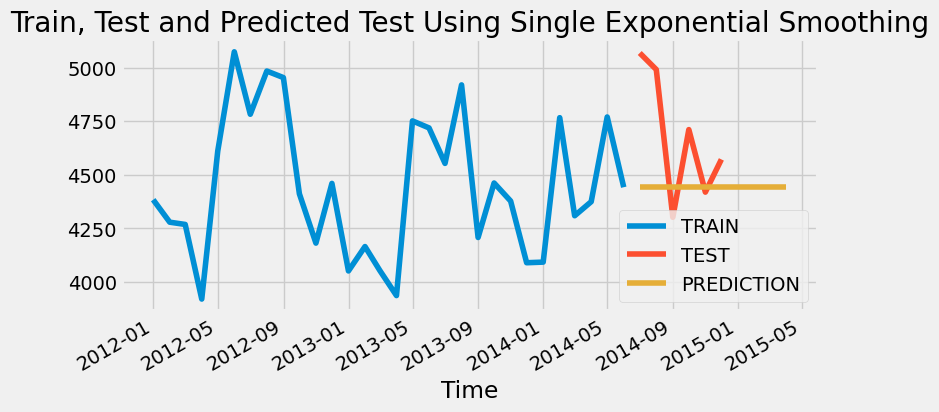

In [ ]:
ses_model = SimpleExpSmoothing(datos2_train_val.Demand).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(10)

def plot_prediction(y_pred, label):
    plt.figure(figsize=(8,4), dpi=100)
    datos2_train_val["Demand"].plot(legend=True, label="TRAIN")
    datos2_test["Demand"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")

#### Double Exponential Smoothing 

In [ ]:
def des_optimizer(train, val, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(datos2_train.Demand, datos2_val.Demand, alphas, betas, step=6)

des_model = ExponentialSmoothing(datos2_train_val.Demand, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(10)


best_alpha: 0.11 best_beta: 0.61 best_mae: 195.8988


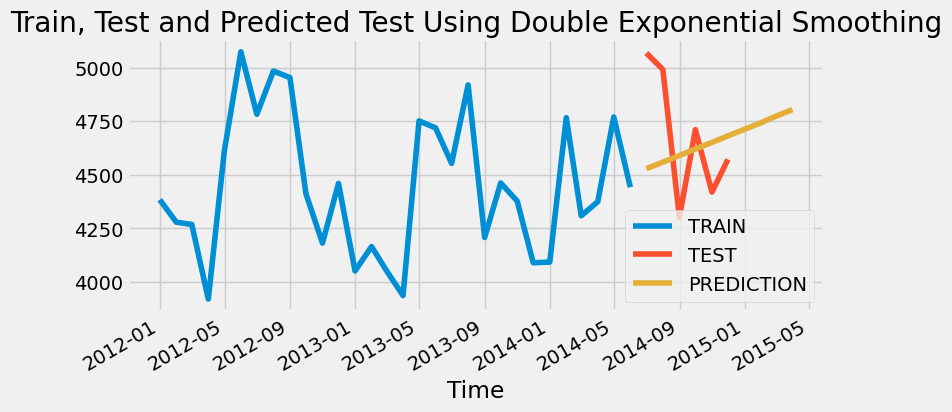

In [ ]:
plot_prediction(y_pred, "Double Exponential Smoothing")

#### Triple Exponential Smoothing

In [ ]:
def tes_optimizer(train, val, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=6).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(datos2_train.Demand, datos2_val.Demand, abg, step=6)

best_alpha: 0.1 best_beta: 0.5 best_gamma: 0.5 best_mae: 197.1223


In [ ]:
tes_model = ExponentialSmoothing(datos2_train_val.Demand, trend="add", seasonal="add", seasonal_periods=6).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(10)

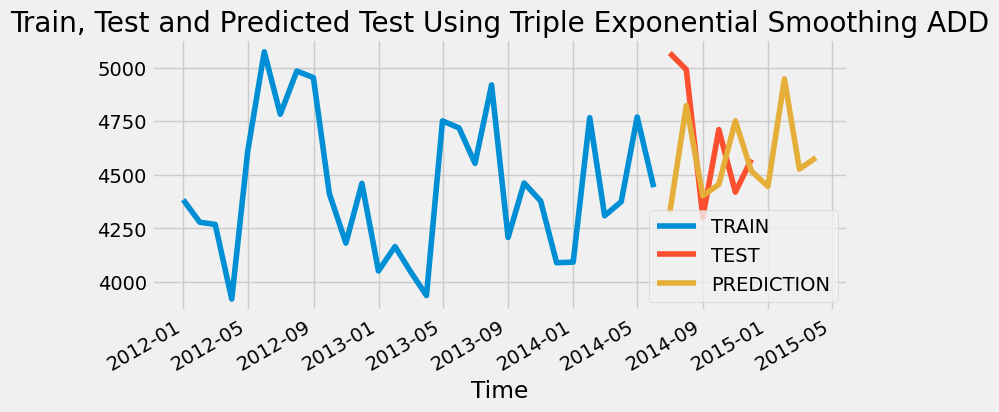

In [ ]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

La predicción no es buena, ya que predice valores crecientes de demanda al final de 2014, cuando el comportamiento real es decreciente. 

### Serie horaria

#### Simple Exponential Smoothing (SES)

In [ ]:
# Separación datos train-val-test para datoszoom ('2013-05-01 14:00:00','2013-06-01 14:00:00')
# ==============================================================================
#datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-05-20 23:59:00'
fin_validacion = '2013-05-25 23:59:00'
datoszoom_train = datos_zoom.loc[:fin_train, :]
datoszoom_val   = datos_zoom.loc[fin_train:fin_validacion, :]
datoszoom_test  = datos_zoom.loc[fin_validacion:, :]
datoszoom_train_val = datos_zoom.loc[:fin_validacion,:]

print(f"Fechas train      : {datoszoom_train.index.min()} --- {datoszoom_train.index.max()}  (n={len(datoszoom_train)})")
print(f"Fechas validacion : {datoszoom_val.index.min()} --- {datoszoom_val.index.max()}  (n={len(datoszoom_val)})")
print(f"Fechas test       : {datoszoom_test.index.min()} --- {datoszoom_test.index.max()}  (n={len(datoszoom_test)})")
print(f"Fechas train_val      : {datoszoom_train_val.index.min()} --- {datoszoom_train_val.index.max()}  (n={len(datoszoom_train_val)})")

Fechas train      : 2013-05-01 14:00:00+10:00 --- 2013-05-20 23:30:00+10:00  (n=932)
Fechas validacion : 2013-05-21 00:00:00+10:00 --- 2013-05-25 23:30:00+10:00  (n=240)
Fechas test       : 2013-05-26 00:00:00+10:00 --- 2013-06-01 14:00:00+10:00  (n=317)
Fechas train_val      : 2013-05-01 14:00:00+10:00 --- 2013-05-25 23:30:00+10:00  (n=1172)


In [ ]:
alphas = np.arange(0.01, 1, 0.10) #(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(datoszoom_train.Demand, datoszoom_val.Demand, alphas, step=240)

best_alpha: 0.21 best_mae: 678.9274


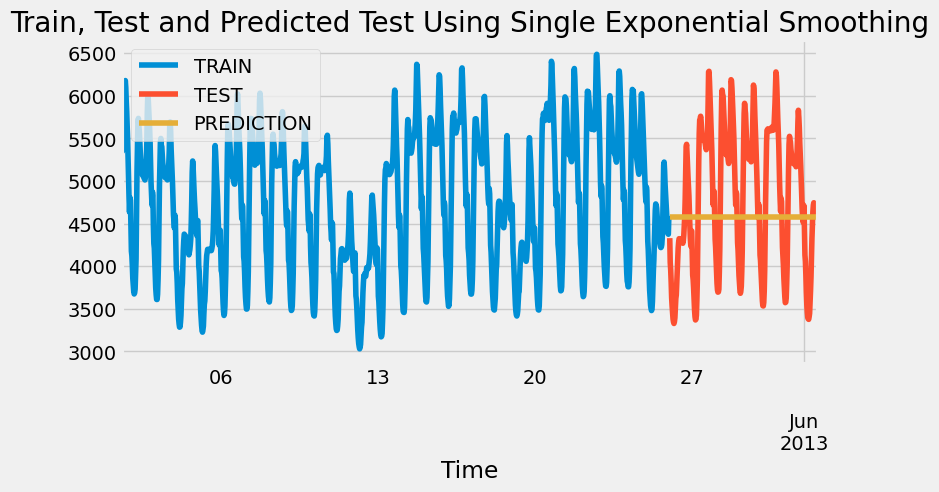

In [ ]:
ses_model = SimpleExpSmoothing(datoszoom_train_val.Demand).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(317)

def plot_prediction(y_pred, label):
    plt.figure(figsize=(8,4), dpi=100)
    datoszoom_train_val["Demand"].plot(legend=True, label="TRAIN")
    datoszoom_test["Demand"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")

#### Double Exponential Smoothing 

In [ ]:
def des_optimizer(train, val, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(datoszoom_train.Demand, datoszoom_val.Demand, alphas, betas, step=240)


des_model = ExponentialSmoothing(datoszoom_train_val.Demand, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(317)

best_alpha: 0.41 best_beta: 0.01 best_mae: 694.995


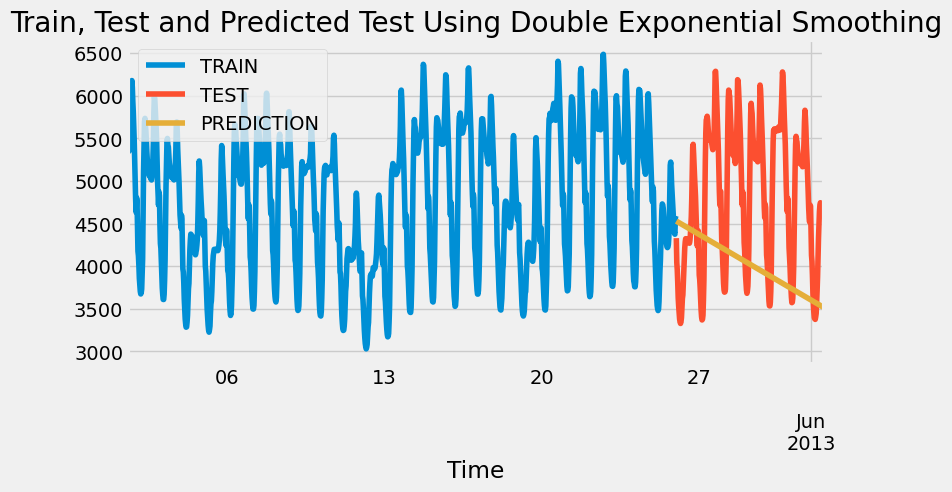

In [ ]:
plot_prediction(y_pred, "Double Exponential Smoothing")

#### Triple Exponential Smoothing

In [ ]:
def tes_optimizer(train, val, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=48).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(datoszoom_train.Demand, datoszoom_val.Demand, abg, step=240)

tes_model = ExponentialSmoothing(datoszoom_train_val.Demand, trend="add", seasonal="add", seasonal_periods=48).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(317)


best_alpha: 0.9 best_beta: 0.9 best_gamma: 0.5 best_mae: 310.2524


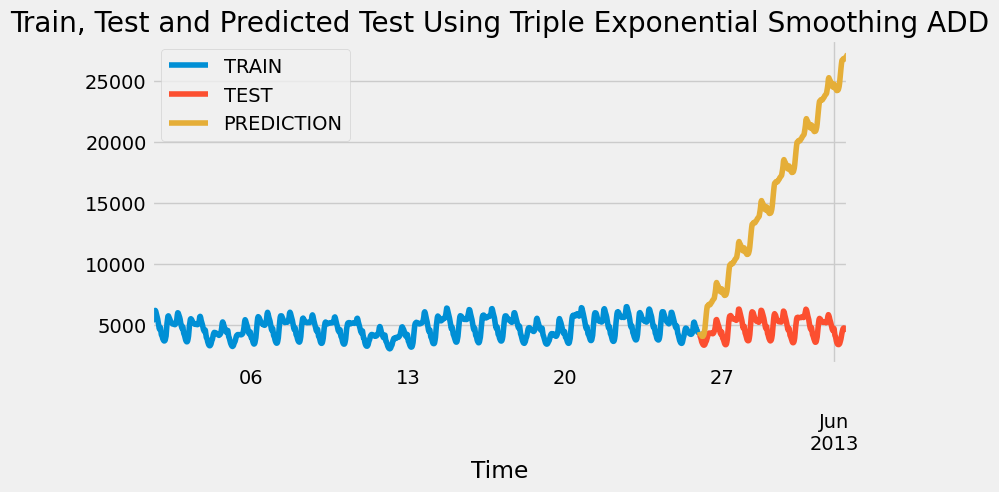

In [ ]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

## Conclusiones

En general los resultados de las predicciones no fueron buenos y no pudimos mejorarlos por falta de tiempo. A continuación, mencionamos algunas cosas que encontramos:
* La serie original presenta una tendencia decreciente. Ninguno de los suavizados exponenciales que realizamos fue capaz de captar tendencia estacionalidad o ciclos. La predicción del modelo Double Exponential Smoothing capta una tendencia creciente.

* La serie mensual también muestra tendencia creciente y la predicción es creciente tanto para el doble como el triple exponential smoothing. Si bien las predicciones tampoco fueron buenas, el Triple Exponential Smoothing con los mejores parámetros encontrados llega a captar los picos y valles del comportamiento de la demanda eléctrica.

* La serie zoom, que habíamos mencionado que mostraba una leve tendencia creciente, capta esta tendencia (aunque exagerada) como así también los ciclos semanales de la demanda con el triple exponential smoothing. El Double Exponential smoothing, por otro lado, predice un comportamiento lineal descendiente.
